## MolMIM Guided Optimization API

This package provides a FastAPI API interface to run MolMIM Guided Optimization.

The Guided Optimization API provides an interface to a single step of the optimization process by taking a list of SMILES and scores as input, computing an updated embedding representation based on the input scores, and decoding an optimized set of molecules based on the updated embeddings.  If no SMILES or scores are provided as input, the Optimization API will generate a starting set of SMILES using the MolMIM `/generate` endpoint.

The API accepts as input:
 - n: The number of desired molecules (`Int`)
 - smiles: List of SMILES (`List[str]`)
 - scores: List of scores for the input SMILES (`List[str]`)
 - sigma: CMA-ES sampling std dev (`Float, range[0. ,2]`)

and returns:
 - smiles: List of optimized SMILES (`List[str]`)

![MolMIM Guided Optimization API diagram](MolMIM-Guided-Optimization-API.png)

### Setup
In this example, we'll define a function based on QED and Tanimoto similarity scores as was used for property optimization in the [MolMIM paper](https://arxiv.org/abs/2208.09016). 
$$
   score = min(QED / 0.9, 1) + min(Tanimoto / 0.4, 1)
$$
This oracle tries to maximize QED and similarity score, up to QED of 0.9 and similarlity of 0.4, beyond which there is no gain.  Note that we return the inverse of the calculated score, as CMA-ES will work to maximize this value.

The following dependencies are required to define this scoring function and visualize the results of the guided optimization.

In [1]:
import numpy as np
import requests
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.QED import qed
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.DataStructs import TanimotoSimilarity
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')


In [2]:
def tanimoto_similarity(smiles, reference: str):
    # Get fingerprint params
    fingerprint_radius_param = 2
    fingerprint_nbits = 2048

    # Handle the reference molecule
    reference_mol = Chem.MolFromSmiles(reference)
    reference_fingerprint = GetMorganFingerprintAsBitVect(
        reference_mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits
    )

    # Validate the other molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0

    fingerprint = GetMorganFingerprintAsBitVect(mol, radius=fingerprint_radius_param, nBits=fingerprint_nbits)

    # Calculate and return the Tanimoto similarity
    return TanimotoSimilarity(fingerprint, reference_fingerprint)
    

In [3]:
def scoring_function(qeds, similarities) -> np.ndarray:
    return -1. * (np.clip(np.array(qeds) / 0.9, a_min=0.0, a_max=1.0) + np.clip(np.array(similarities) / 0.4, a_min=0.0, a_max=1.0))


### Optimization

The following code block defines the optimization loop and displays the scores of the optimized molecules in the (QED, similarity) scoring space.

Within this optimization loop we:
1. Test for valid SMILES
2. Calculate the QED, Tanimoto Similarity, and combined score using the oracle scoring function
3. Construct the call to the optimizer API using the SMILES and scores
4. Submit a request to the optimizer API for a new set of optimized SMILES



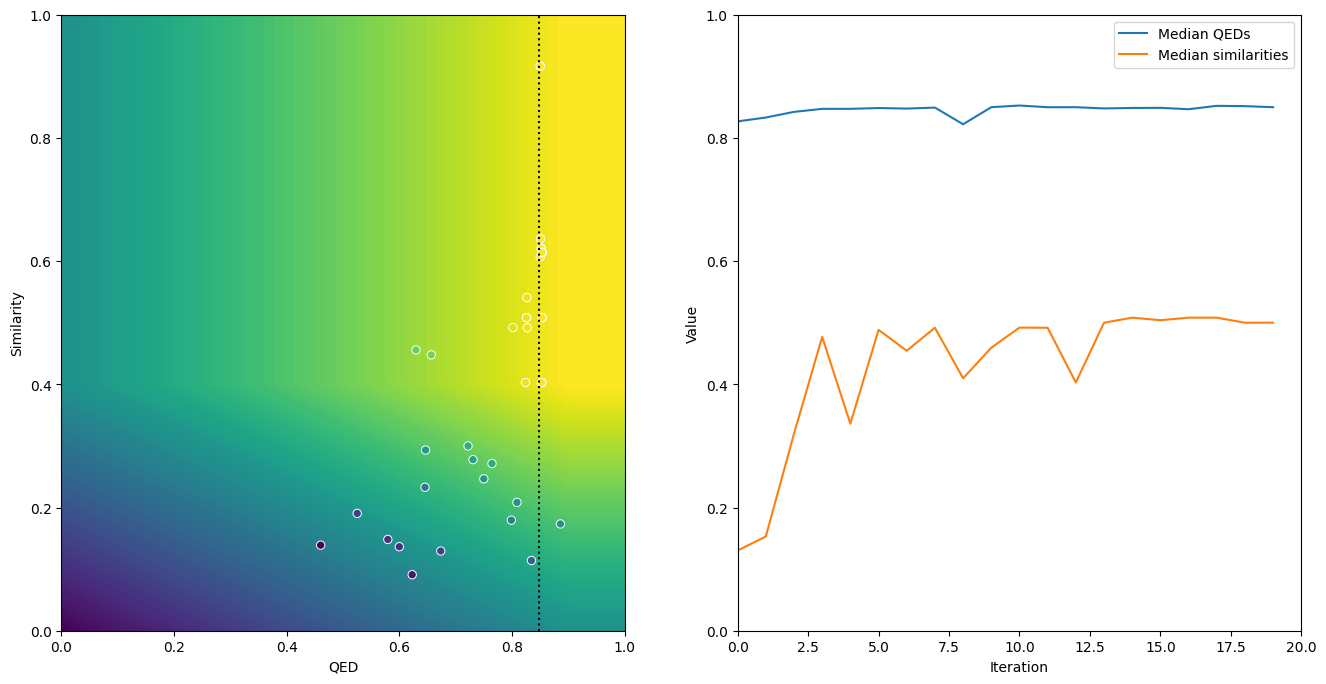

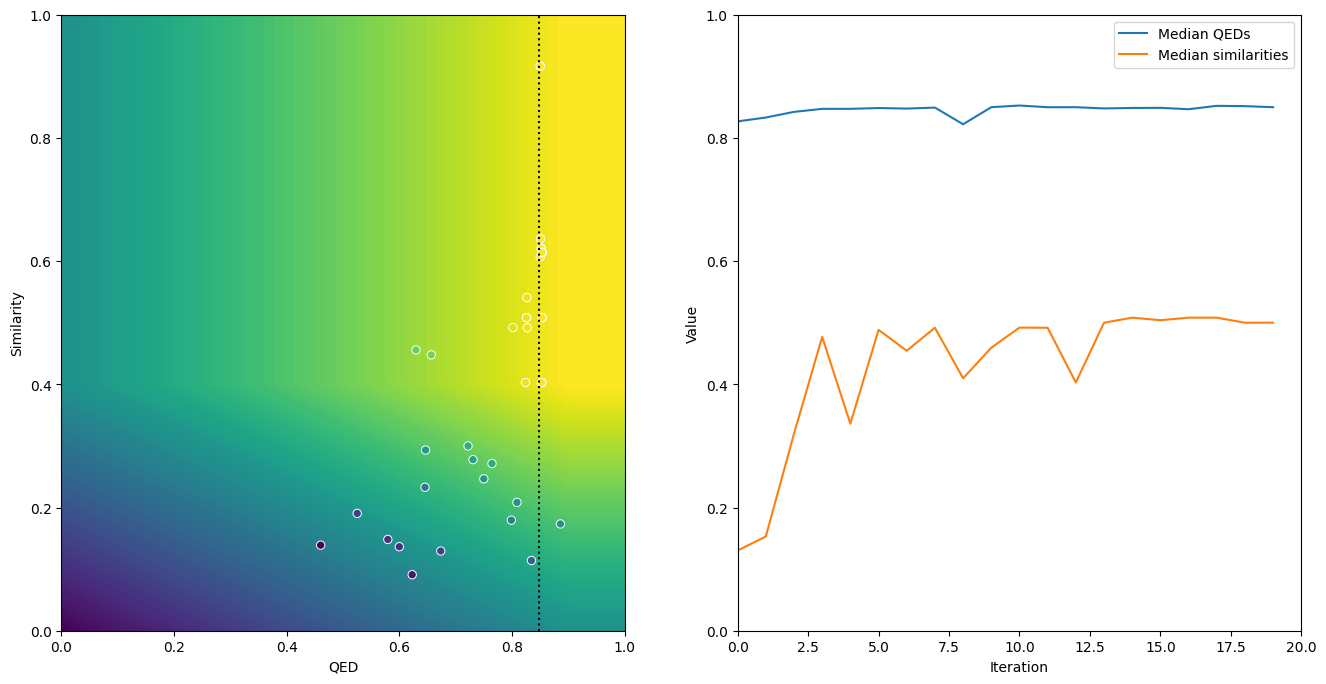

In [15]:
%matplotlib inline

# Define plot layout and vars
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(8)
fig.set_figwidth(16)
med_qeds = []
med_sims = []
deltas = np.linspace(0, 1, 100)
Xgrid, Ygrid = np.meshgrid(deltas, deltas)
score_background = -1*scoring_function(Xgrid, Ygrid)


# Define the optimizer API endpoint, assuming we're running locally
optimizer_endpoint = "http://localhost:8080/optimize/"

# Test case: define seed and an array of 10 input SMILES
seed = 'c1ccc(CN2CC[C@@H]2CNCc2nc(C3CCCC3)no2)cc1'
init_qed=qed(Chem.MolFromSmiles(seed))

smiles = [
    'CC(C)(C)c1ccc(CCC(=O)O)cc1',
    'NC(=O)C[C@@H]1C[C@H](NC(=O)c2cc(NC(=O)c3ccccc3)ccc2F)C1', 
    'CSc1ccc2c(c1)CC[C@H]2NC(=O)NCCCc1nccs1', 
    'CCn1cnc2ccc(NC(=O)C3CCN(C(=O)C(C)(C)C)CC3)cc21', 
    'COC(=O)[C@@H]1CCC[C@@H]1C(=O)N[C@@H](C)c1cnn(C)c1C', 
    'C[C@H]1C[C@@H]1C(=O)N1C[C@@H](NC(=O)COCCc2ccccc2)C(C)(C)C1', 
    'N[C@@H]1CCC[C@]12C[C@@H]2C(=O)Nc1nc2c(s1)CCC2', 
    'CCCCCC(=O)N[C@H]1C[C@H]2CC[C@@H]1N2Cc1nc(C(C)C)no1', 
    'O=C(O)c1ccc(CC(=O)N2CC[C@H](C(=O)O)C[C@@H]2[C@H]2CCCO2)cc1', 
    'c1ccc(CN2CC[C@@H]2CNCc2nc(C3CCCC3)no2)cc1'
]

# Optimization loop
sigma=1.5  # CMA-ES sampling std dev

nsteps=20
for i in range(nsteps):

    # Define vars for scoring and validating SMILES
    tanimoto_scores = []
    qed_scores = []
    valid_smiles = []

    # Test for valid SMILES and calculate QED, Similarity
    for smile in smiles:        
        mol = Chem.MolFromSmiles(smile)
        if mol:
            valid_smiles.append(smile)
            tanimoto = tanimoto_similarity(smile, seed)
            qed_score = qed(mol)
            tanimoto_scores.append(tanimoto)
            qed_scores.append(qed_score)
    
    # Calculate combined oracle score for valid SMILES
    scores = scoring_function(qed_scores, tanimoto_scores)
    scorelist=scores.tolist()
    
    # Build the request data
    data = {'n': 50,
            'smiles': valid_smiles,
            'scores': scorelist,
            'sigma': sigma}

    # Send the request and get the response
    headers = {'Content-Type': 'application/json'}
    response = requests.post(optimizer_endpoint, headers=headers, json=data)
    smiles = response.json()['generated']
    #print(f"{len(set(smiles))} unique smiles at step {i}")
    

    
    # Plot the resulting scores in (QED, Similarity) space
    colors=-1*scores
    ax1.clear()
    # NOTE: comment clear_output() to preserve all plots and stdout
    clear_output(wait=True)
    ax1.contourf(Xgrid, Ygrid, score_background, levels=100, vmin=0, vmax=2.0)
    ax1.set_xlabel('QED')
    ax1.set_ylabel('Similarity')
    ax1.plot([init_qed, init_qed], [0, 1], linestyle=':', c='k', label="Original QED")
    ax1.scatter(qed_scores, tanimoto_scores, c=colors, edgecolor='1.0', linewidths=0.7)
    
    ax2.clear()
    med_qeds.append(np.median(qed_scores))
    med_sims.append(np.median(tanimoto_scores))
    ax2.plot(med_qeds, label='Median QEDs')
    ax2.plot(med_sims, label='Median similarities')
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Value")
    ax2.set_xlim(0, nsteps)
    ax2.set_ylim(0, 1)
    ax2.legend()
    display(fig)




### Analysis
Now we can visualize the resulting candidate molecules.  We'll look at the initial seed for which we calculated Tanimoto similarity and the top five optimized molecules.

In [16]:
# sort the scores of optimized valid_smiles
top5ind = sorted(range(len(scores)), key=lambda x: scores[x])[-5:]
topsmiles = [valid_smiles[i] for i in top5ind]
topsmiles.insert(0,seed)

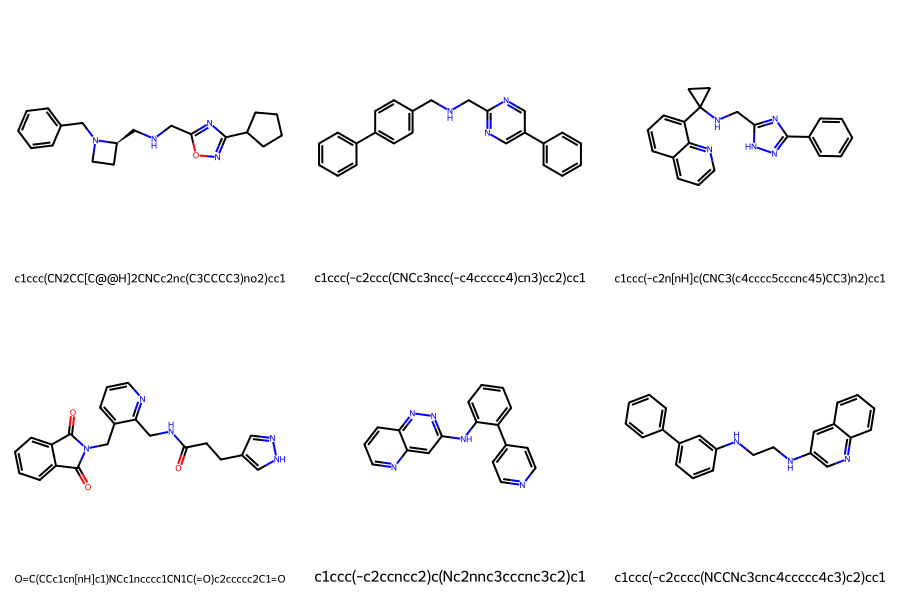

In [17]:
Draw.MolsToGridImage([Chem.MolFromSmiles(smile, sanitize=False) for smile in topsmiles],
                     legends=topsmiles, molsPerRow=3, subImgSize=(300, 300))